In [150]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from unagi import config
from unagi import hsc
from unagi import mask
from unagi import plotting
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Get the HSC cutout image

* I pick one GAMA edge on galaxy from my own sample at $z=0.114$ with a $\log M_{\star}=10.86$
* This is a pretty easy case: there are a few bright stars and galaxies around, but nothing too close to the galaxy.
* $\rm RA = 177.56837$, $\rm Dec = -0.396286$
* We will use the $i$-band image as reference
* We will download the science image, object mask, and the variance image (uncertainty of flux at pixel level).

# Retrieving cutout image in filter: i


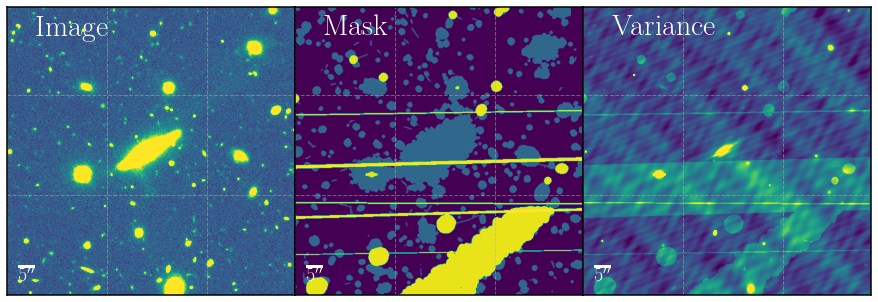

In [60]:
# Download an example mask plane
ra_obj, dec_obj = 177.56837, -0.396286
coord = SkyCoord(ra_obj, dec_obj, frame='icrs', unit='deg')

# Size of the cutout should be large enough to contain all the fluxes of the galaxy
#    we want to study and also leave enough space to evaluate background level.
s_phy = 100.0 * u.kpc
redshift = 0.114

cutout_edge = hsc_cutout(
    coord, cutout_size=s_phy, filters='i', archive=pdr2, redshift=redshift,
    use_saved=False, verbose=True, save_output=True, mask=True, variance=True, 
    prefix='edgeon_demo')

label_list = [r"$\rm {}$".format(label) for label in ['Image', 'Mask', 'Variance']]
_ = plotting.display_all(
    cutout_edge, hdu_list=True, img_size=4, label_list=label_list, 
    fontsize=30, fontcolor='w')

In [122]:
# The cutout_edge is a `HDUList`, if we just want the 2-D array, we need to do this:
i_img = cutout_edge[1].data
i_msk = cutout_edge[2].data
i_var = cutout_edge[3].data

### Detection

* The pixel value on the science image reflects the flux density measured at a given pixel. We call it "flux density" because we normalize the flux to the total (or effective) exposure time.
    - This is the science **signal** we rely on.
* The flux density value has been calibrated to system called the [AB magnitude system](https://en.wikipedia.org/wiki/AB_magnitude)
* For a flux measurement at any given HSC band, you can convert the image pixel value into AB magnitude using a constant **zeropoint=27.0 mag**.
    - $m_{\rm AB} = -2.5 \log_{10}f_{\rm pixel} + 27.0$
    - The magnitude system does not really much sense outside astronomy, but it has been adopdate for weird reasons for more than a century...so it is very hard to change. Just keep reminding yourself that brigther object has higher flux, but has lower value in the magnitude system.
* At the same time, the variance map provides measurements of the uncertainty of flux density measurement.
    - In some way, it measure the **noise** of the signal we want to detect. But also remember that this is not just the statistical "noise" or random uncertainties but also include **systematic uncertainties**.
    - Also remember that variance is square of the uncertainty value.
* There is a lot to be said in the **detection** of astronomical object.
    - But, to the zeroth order, we basically apply a signal-to-noise (S/N) ratio cut to the image. e.g. We only think we actually detect something when S/N > 5. We can naively call this a "5-sigma" detection.
    - This will give us all the pixels with flux density value above certain significance level.

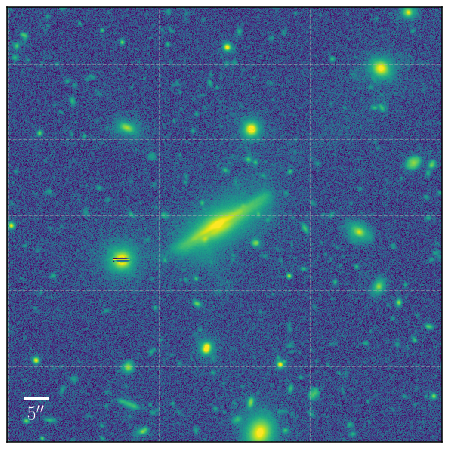

In [123]:
# Convert the variance map into uncertainty map (or `sigma` map).
i_sig = np.sqrt(i_var)

# Then we can get a simple S/N map
i_s2n = i_img / i_sig

# Although this looks very similar to the science image, the value distribution is different.
# This is what the object detection algorithm "sees". 
# Notice that this is very over-simplified: S/N can't be negative; 
#    but we are dealing with background subtracted image, so a lot of the pixels
#    have negative values. This doesn't mean the pixel has "negative" flux, but 
#    the pixel value is below the mean background level.

_ = plotting.display_single(i_s2n)

### Mask plane

* Please see [this demo](https://github.com/dr-guangtou/unagi/blob/master/demo/demo_hsc_mask.ipynb) to understand the meaning of each mask plane
* We want to extract masks for:
    1. **Bad pixels**: e.g. saturated pixels. We don't want to include these pixels in any analysis
    2. **Detections**: pixel in this mask plane belong to certain "object" that is above a S/N threshold.
    3. **Bright star**: regions that are affected by a bright star.

['SAT', 'INTRP', 'CR', 'DETECTED', 'NO_DATA', 'REJECTED', 'CLIPPED', 'SENSOR_EDGE', 'INEXACT_PSF']


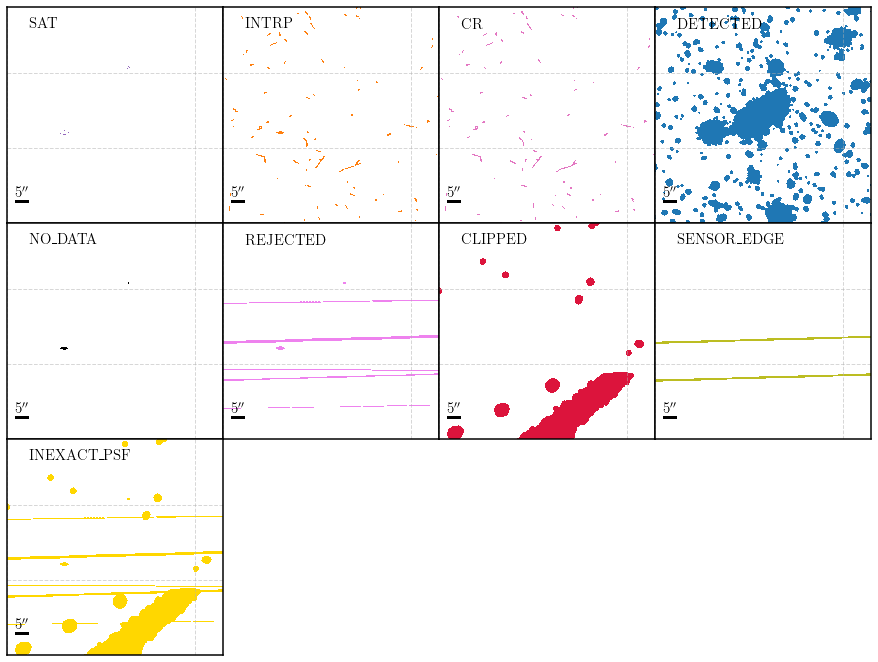

In [63]:
# We first convert the single mask plane into something that is easier to understand
mask_edge = mask.Mask(i_msk, data_release='pdr2')

# The following mask planes are occupied
print(mask_edge.name_used())

# Visualizing these mask planes can help you understand what's going on during the image reduction process.
# So we have a few saturated pixels which we will need to mask out (SAT & NO_DATA)
# CR stands for cosmic ray, these pixels have been interpolated over (INTRP)
# We don't have bright star mask on this image.
_, mm = mask_edge.show_used()

In [135]:
# We will extract and combine a few mask planes
mask_detect = mask_edge.extract('DETECTED')

# NO_DATA and SAT planes are combined into a "bad" pixel mask
mask_bad = mask_edge.combine(['NO_DATA', 'SAT'])

# Cosmic ray, edge of the CCD also affect the signal we want to detect, but the image reduction pipeline can 
#     reasonably mitigate their impacts.

## Source Extraction and Segmentation

* On the `DETECTED` mask plane, we already know all the pixels that belong to certain object. So if we could just exclude the central galaxy we want to study, we already have a mask.
* However that's the difficult part. The process of figuring out which pixel belong to which object is called **object extraction**; and often the flux density in a pixel comes from different objects, or we can say that the flux distributions of several objects are **blended** together. The process of separating the contributions from different objects is called **deblending**. This is a very difficult problem. But the simplest approach is called **image segmentation**. It basically assumes that one pixel can only belong to one object. The **segmentation** process basically tries to draw boundaries between objects. The final product is a **segmentation map**. On this map, the pixels belong to the same object have the same integer pixel value that can be used as the index of the object.
* Although this is not perfect in many, many cases, it is often good enough for us to generate an object mask for photometric analysis of a single galaxy.

#### `Photutils`

* `photutils` is a `astropy`-affiliated Python package for photometry. 
    - `pip install --upgrade photutils` can install this package.

* `photutils` provides the basic function of object detection and image segmentation. 
    - It is not the most efficient one, but it is easy to use.
    - Please see [detailed explanation here](https://photutils.readthedocs.io/en/stable/segmentation.html)
    - It only uses three main functions: [`detect_threshold`](https://photutils.readthedocs.io/en/stable/api/photutils.detection.detect_threshold.html#photutils.detection.detect_threshold), [`detect_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html), and [`deblend_sources`](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html#photutils.segmentation.deblend_sources).
    - You can also learn about how to find the **peaks** of flux density distribution and find stars using the [demo here](https://photutils.readthedocs.io/en/stable/detection.html)

In [65]:
from photutils import detect_threshold
from photutils import detect_sources
from photutils import deblend_sources

from astropy.convolution import Gaussian2DKernel

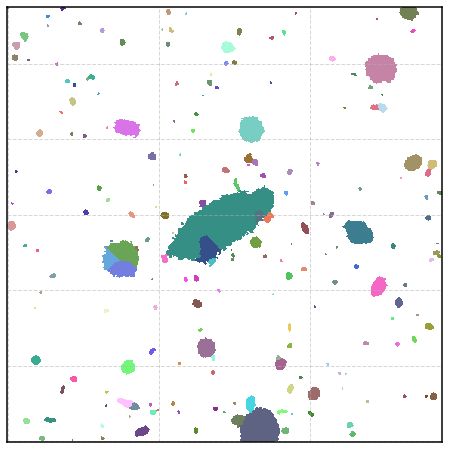

In [124]:
# This process has a few parameters to tweak with:

# 1. Detection threshold: lower value means larger fraction of pixels will be included in the process
#    higher value means we only consider the really significant (bright) parts.
threshold = 2.0 # sigma detection

# 2. Sigma of the 2-D Gaussian kernel used to suppress the noise fluctuation.
gaussian_sigma = 1.0

# 3. Minimum number of connected pixels in an object.
npixels = 5 # A tiny dot with < 5 connected pixels won't be considered as a real "object"

# 4. This is a little hard to explain. But you can consider it as the "aggressiveness" of 
#     deblending process. Lower value means the algorithm will try to deblend it into fewer 
#     number of sub-objects; higher value means the "deblender" will be very aggressives
nlevels = 64

# 5. The fraction of the total (blended) source flux that a local peak must have 
#    (at any one of the multi-thresholds) to be considered as a separate object.
#    Value is between 0 and 1; 0 means all peaks become individual object; 1 means no deblending.
contrast = 0.0001

# Please feel free to play with these parameters and check the result. 
# When you try to wrap this up in a function, these are the parameters you need to use.


# Determine the S/N threshold
i_thr = detect_threshold(i_img, threshold, background=None, error=i_sig, mask=mask_bad)

# Use 2D circular Gaussian kernel with a sigma=3 pixel to smooth the image some prior to thresholding
# This is a way to remove all the isolated tiny "objects" that are not real but due to noise fluctuation
# at the low surface brightness part of the image. You can try to set filter_kernel=None to see what
# will happen.
kernel = Gaussian2DKernel(gaussian_sigma, x_size=5, y_size=5)
kernel.normalize()

# Get the initial segementation map
i_seg = detect_sources(
    i_img, i_thr, npixels=npixels, connectivity=8, filter_kernel=kernel)

# Get the real segementation map
# Here the two key parameters are `nlevels` and `contrast`
i_seg = deblend_sources(
    i_img, i_seg, npixels=npixels, filter_kernel=kernel, 
    nlevels=nlevels, contrast=contrast, relabel=False)

# We use random colors to highlight the segmentation maps
seg_cmap = plotting.random_cmap(ncolors=256)

_ = plotting.display_single(
    i_seg.data, stretch='linear', scale='minmax', cmap=seg_cmap)

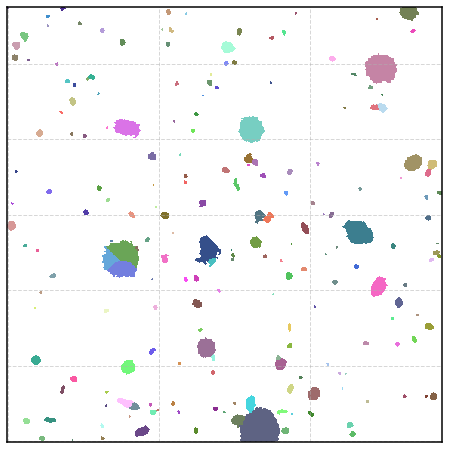

In [125]:
# We put our galaxy at the center of the image, so now we want to remove it from the segmentation map
#    before we use it as a mask

def seg_remove_cen_obj(seg):
    """Remove the central object from the segmentation."""
    seg_copy = copy.deepcopy(seg)
    seg_copy[seg == seg[int(seg.shape[0] / 2.0), int(seg.shape[1] / 2.0)]] = 0

    return seg_copy

i_obj = seg_remove_cen_obj(i_seg.data)

_ = plotting.display_single(
    i_obj, stretch='linear', scale='minmax', cmap=seg_cmap)

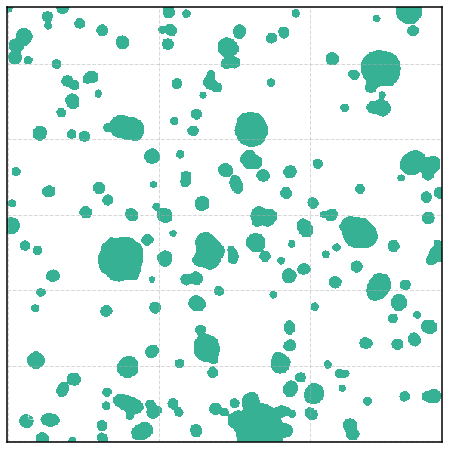

In [211]:
# To be conservative, we also need to increase the mask size a little 
#    using image smoothing method. 
# We can use uniform smoothing (box) or Gaussian kernel smoothing.

def increase_mask_regions(mask, method='uniform', size=5, mask_threshold=0.01):
    """Increase the size of the mask regions using smoothing algorithm."""
    mask_arr = mask.astype('int16')
    mask_arr[mask_arr > 0] = 100
    
    if method == 'uniform' or method == 'box':
        mask_new = ndimage.uniform_filter(mask_arr, size=size)
    elif method == 'gaussian':
        mask_new = ndimage.gaussian_filter(
            mask_arr, sigma=size, order=0)
    else:
        raise ValueError("Wrong method. Should be uniform or gaussian.")
    
    mask_new[mask_new < mask_threshold] = 0
    mask_new[mask_new >= mask_threshold] = 1
    
    return mask_new.astype('uint8')

mask_obj = increase_mask_regions(i_obj, method='gaussian', size=3, mask_threshold=3)

_ = plotting.display_single(
    mask_obj, stretch='linear', scale='minmax', cmap=seg_cmap)

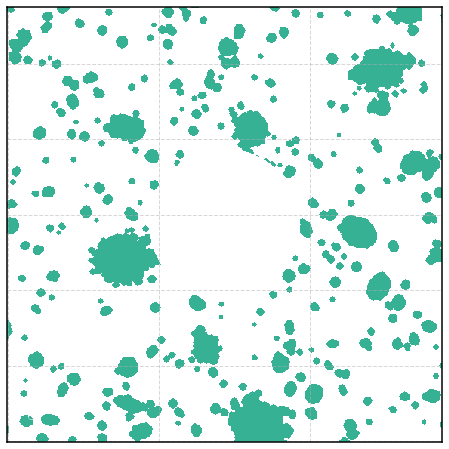

In [207]:
# Notice that the original HSC detection mask is better at covering the low surface brightness
#    part of galaxies. We should use it in the outskirt of the image.

def create_circular_mask(img, center=None, radius=None):
    """Create a circular mask to apply to an image.
    
    Based on https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    """
    h, w = img.shape
    
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# Clear out the inner region
cen_mask = create_circular_mask(i_img, radius=100)
mask_hsc = copy.deepcopy(mask_detect)
mask_hsc[cen_mask] = False

_ = plotting.display_single(
    mask_hsc.astype('float'), stretch='linear', scale='minmax', cmap=seg_cmap)

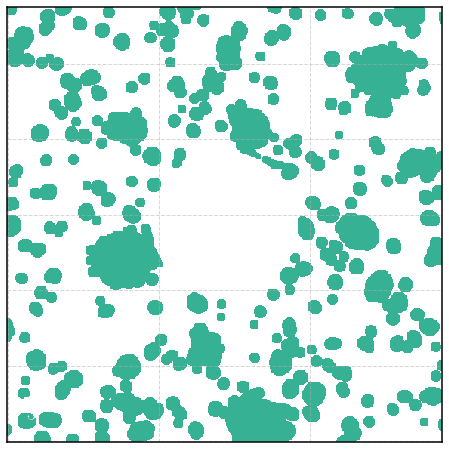

In [215]:
# We do the same to the hsc mask to increase the mask region
mask_hsc_new = increase_mask_regions(
    mask_hsc, method='uniform', size=7, mask_threshold=3)

_ = plotting.display_single(
    mask_hsc_new, stretch='linear', scale='minmax', cmap=seg_cmap)

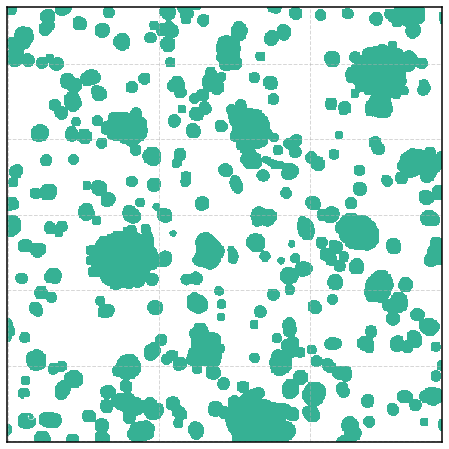

In [216]:
# Now we can combine the mask from HSC detection, from our own process into one object mask
mask_final = (mask_obj | mask_hsc_new)

_ = plotting.display_single(
    mask_final.astype('float'), stretch='linear', scale='minmax', cmap=seg_cmap)

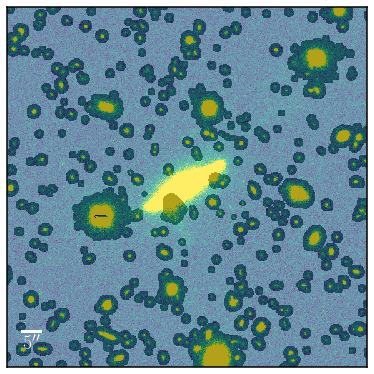

In [218]:
# We can show the effect of the mask on top of the image
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

ax1 = fig.add_subplot(111)
ax1.grid(False)

ax1 = plotting.display_single(i_img, contrast=0.3, ax=ax1)

ax1.imshow(
    mask_final.astype('float'), origin='lower', interpolation='none', 
    cmap='Greys', alpha=0.3)